In [1]:
# --- CELL 1: IMPORT THƯ VIỆN ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


In [62]:
# --- CELL 2: BƯỚC 1 - CẮT BIỂN SỐ (LOGIC CANNY THUẦN) ---
def step1_detect_plate(image_path):
    # 1. Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        print("Lỗi: Không đọc được ảnh.")
        return None

    # --- TIỀN XỬ LÝ ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Tạo ảnh nhị phân (chỉ để hiển thị)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Canny Edge 
    edged = cv2.Canny(blur, 30, 150)
    
    # --- QUAY LẠI LOGIC CŨ: TÌM CONTOUR TRỰC TIẾP TRÊN CANNY ---
    # Không dùng Morphology Closing nữa để tránh làm dày/dính nét
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    plate_img = None
    found_contour = None
    debug_box = None
    status_text = "Không tìm thấy"
    
    for c in contours:
        rect = cv2.minAreaRect(c)
        (center, (w, h), angle) = rect

        # Chuẩn hóa w, h
        if w < h:
            w, h = h, w
            angle += 90
        if angle > 45: angle -= 90
        elif angle < -45: angle += 90
        
        aspect_ratio = w / float(h)
        area = w * h
        
        # Logic lọc biển số
        if aspect_ratio > 1.8 and aspect_ratio < 6.0 and area > 1500:
            found_contour = c
            
            # Logic xoay ảnh
            if abs(angle) < 30:
                status_text = f"Đã xoay (Góc {int(angle)}°)"
                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                rotated_full_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
                
                center_homogeneous = np.array([center[0], center[1], 1.0])
                new_center = M.dot(center_homogeneous)
                new_center = (new_center[0], new_center[1])
                
                plate_img = cv2.getRectSubPix(rotated_full_img, (int(w), int(h)), new_center)
                
                box = cv2.boxPoints(rect)
                debug_box = np.int32(box)
            else:
                status_text = f"Cắt thẳng (Góc {int(angle)}° > 30°)"
                x, y, w_b, h_b = cv2.boundingRect(c)
                plate_img = img[y:y+h_b, x:x+w_b]
                debug_box = np.array([[x,y], [x+w_b, y], [x+w_b, y+h_b], [x, y+h_b]], dtype=np.int32)
            
            break
            
    # --- 3. HIỂN THỊ CHI TIẾT ---
    fig, ax = plt.subplots(2, 3, figsize=(18, 10))
    
    # Hàng 1
    debug_img = img.copy()
    if found_contour is not None:
        cv2.drawContours(debug_img, [found_contour], -1, (0, 255, 0), 2) # Viền xanh
        if debug_box is not None:
            cv2.drawContours(debug_img, [debug_box], 0, (255, 0, 0), 2) # Viền đỏ
            
    ax[0, 0].imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title(f"1. Phát hiện: {status_text}")
    
    ax[0, 1].imshow(gray, cmap='gray')
    ax[0, 1].set_title("2. Ảnh Xám")
    
    ax[0, 2].imshow(blur, cmap='gray')
    ax[0, 2].set_title("3. Blur")

    # Hàng 2
    ax[1, 0].imshow(binary, cmap='gray')
    ax[1, 0].set_title("4. Nhị phân")
    
    ax[1, 1].imshow(edged, cmap='gray')
    ax[1, 1].set_title("5. Canny Edges (Logic cũ)")

    if plate_img is not None:
        ax[1, 2].imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
        ax[1, 2].set_title("6. Kết quả")
    else:
        ax[1, 2].text(0.5, 0.5, "Không tìm thấy biển", ha='center', fontsize=12)
        ax[1, 2].set_title("6. Thất bại")

    for row in ax:
        for col in row: col.axis('off')
    plt.tight_layout()
    plt.show()

    if plate_img is None:
        return None
    
    return plate_img

In [45]:
# --- CELL 3: BƯỚC 2 - TÁCH KÝ TỰ (CẬP NHẬT: ADAPTIVE THRESHOLD) ---
def step2_segment_characters(plate_img):
    if plate_img is None: return

    # 1. Resize ảnh biển số
    h_plate, w_plate = plate_img.shape[:2]
    new_h = 60 # Chiều cao cố định
    new_w = int(new_h * (w_plate / h_plate))
    plate_resized = cv2.resize(plate_img, (new_w, new_h))

    # 2. Xử lý ảnh
    gray = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2GRAY)
    
    # --- THAY ĐỔI QUAN TRỌNG: DÙNG ADAPTIVE THRESHOLD ---
    # Thay vì Otsu (Global), ta dùng Adaptive (Local) để xử lý bóng đổ/ánh sáng không đều
    # Block Size = 11, C = 2
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # ---------------------------------------------------

    # 3. Tìm Contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    char_list = []

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        
        aspect_ratio = w / float(h)
        height_ratio = h / float(new_h)
        area = w * h

        # --- BỘ LỌC KÝ TỰ ---
        # 1. Chiều cao: 0.25 - 0.95 (Bắt được cả biển 2 dòng và 1 dòng)
        # 2. Tỷ lệ: 0.15 - 1.5 (Bắt được số 1 thon và số 0 bè)
        # 3. Diện tích: > 60 (Giảm nhẹ để bắt các dấu chấm hoặc chữ nhỏ)
        
        if 0.25 < height_ratio < 0.95:
            if 0.15 < aspect_ratio < 1.5:
                if area > 60: 
                    roi = binary[y:y+h, x:x+w]
                    char_list.append((x, y, w, h, roi))

    # 4. Sắp xếp ký tự
    # Logic sắp xếp cơ bản theo trục X (với biển 2 dòng cần logic phức tạp hơn, nhưng tạm thời dùng cái này để hiển thị)
    char_list = sorted(char_list, key=lambda k: k[0])

    # --- HIỂN THỊ ---
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(cv2.cvtColor(plate_resized, cv2.COLOR_BGR2RGB))
    ax[0].set_title("1. Biển số (Resize)")
    
    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title("2. Adaptive Threshold (Xử lý bóng đổ)")
    
    result_img = plate_resized.copy()
    for (x, y, w, h, _) in char_list:
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    ax[2].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title(f"3. Đã tách {len(char_list)} ký tự")
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Bước 2 hoàn tất: Tìm thấy {len(char_list)} ký tự.")

Đang xử lý ảnh: ./1.jpg


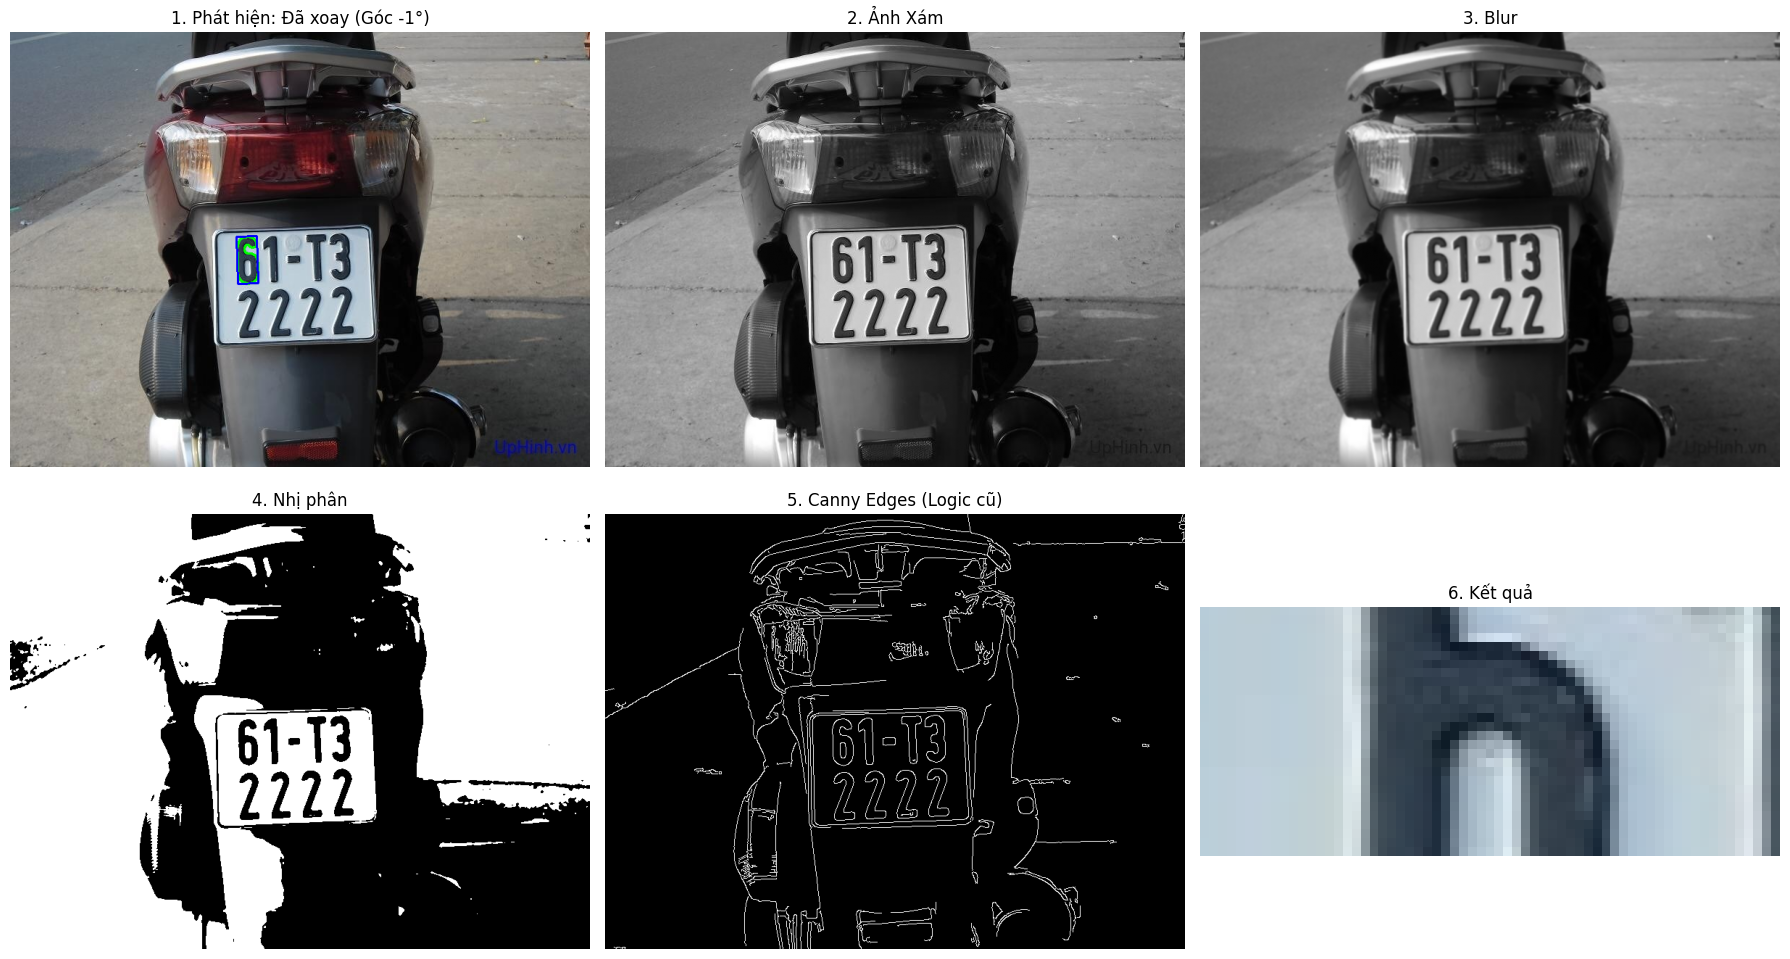

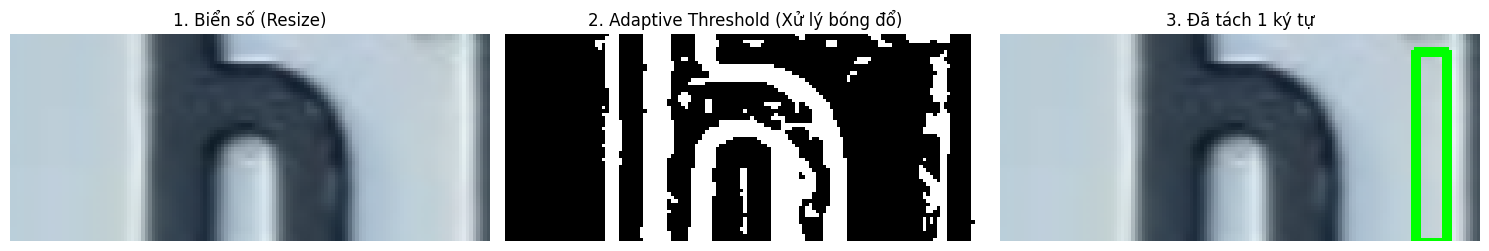

Bước 2 hoàn tất: Tìm thấy 1 ký tự.


In [100]:
# --- CELL 4: CHẠY THỬ NGHIỆM ---

# Thay đường dẫn ảnh của bạn vào đây
image_path = './1.jpg' 

print(f"Đang xử lý ảnh: {image_path}")

# 1. Gọi Bước 1
cropped_plate = step1_detect_plate(image_path)

# 2. Nếu Bước 1 thành công -> Gọi Bước 2
if cropped_plate is not None:
    step2_segment_characters(cropped_plate)
else:
    original_img = cv2.imread(image_path)
    
    if original_img is not None:
        step2_segment_characters(original_img)
    else:
        print("Lỗi: Không đọc được ảnh gốc.")